# SIBI Alphabet Classifier for Edge TPU

This notebook contains the code to train Machine Learning model to recognize Sistem Isyarat Bahasa Indonesia (SIBI) or Indonesian sign language. The model is limited to only recognizing static alphabet of SIBI and not other kind of sign such as words, phrases, or numbers.

This notebook is based on Google Notebook of Re-training MobileNetV2 for Image Classification.

## Importing the dataset

For this purpose, I am using premade dataset from Kaggle titled 'Sistem Isyarat Bahasa Indonesia (SIBI)' by Alvin Bintang. This dataset contains 220 images for each static alphabets (everything except j and z) totaling 5280 images.

The codes below are intended for importing Kaggle dataset to Google Colab. If you have your own dataset or you're working on local machine with Jupyter Notebook or other applications, you can safely skip this section.

In [1]:
from pathlib import Path

data_dir = Path("D:/Test/SIBI/")

## Importing the library needed

In [2]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

In [18]:
from keras.preprocessing.image import ImageDataGenerator
IMAGE_SIZE = 224
BATCH_SIZE = 64

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=123, 
    subset='training')

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=123, 
    subset='validation')

Found 5280 files belonging to 24 classes.
Using 4224 files for training.
Found 5280 files belonging to 24 classes.
Using 1056 files for validation.


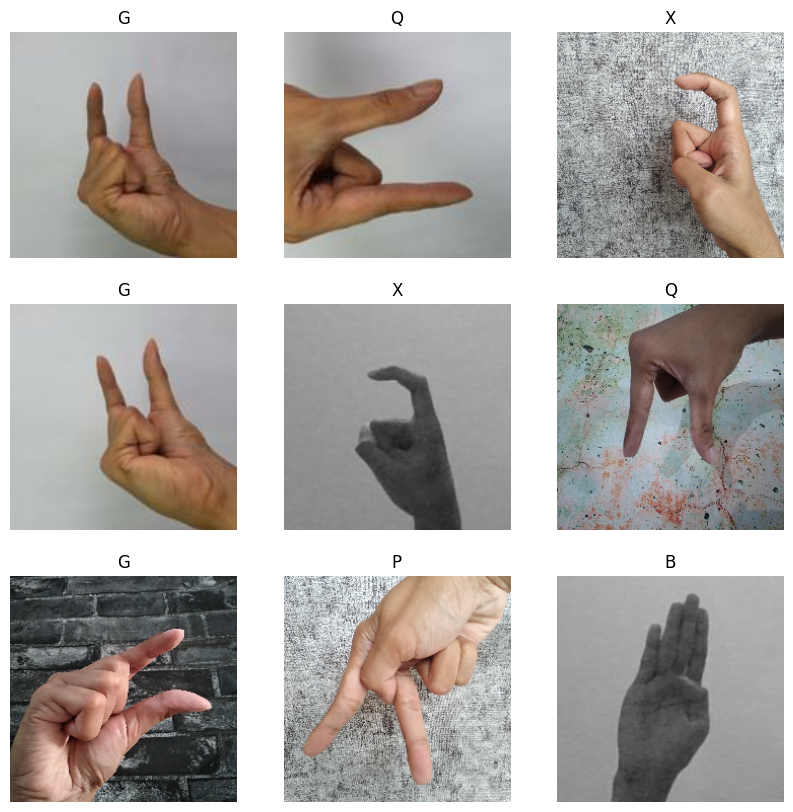

In [19]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 14
Number of test batches: 3


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [55]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 18s 2us/step


In [56]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [57]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


In [66]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [67]:
num_classes = len(class_names)

prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 24)


In [69]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [74]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [75]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 1280)        0         
                                                           

In [76]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
65/66 [============================>.] - ETA: 6s - loss: 4.9828 - accuracy: 0.1091 

KeyboardInterrupt: 